In [6]:
import numpy as np 
from vstats import *
from thermodynamics import *
import netCDF4 as nc
import matplotlib.pyplot as plt
import smooth as sm 
%pylab inline
pylab.rcParams['figure.figsize'] = (8.0, 8.0)

Populating the interactive namespace from numpy and matplotlib


In [7]:
class TimeSeries:
    def __init__(self, time, z = []):
        '''minimum thing to define a time series. can also include a z dimension''' 
        self.time = time 
        self.z = z 

### read in data 

In [5]:
gstats_after = nc.Dataset('../data/globalstats/globalstats_fastcloud_2xco2_0.nc')
vstats_after = nc.Dataset('../data/verticalstats/verticalstats_fastcloud_2xco2_0.nc')

In [21]:
## make the time variable for the whole pre-doubling equilibration run
pretime_global = np.zeros(0)
pretime_vertical = np.zeros(0)
for i in range(0,12):
    filename = "../data/globalstats/globalstats_fastcloud_" + str(i) + ".nc"
    filename_v = "../data/verticalstats/verticalstats_fastcloud_" + str(i) + ".nc"
    tmp = nc.Dataset(filename)
    time_tmp = getvar('time',tmp) + 10.*i  # assumes all files have 10 days in them
    pretime_global = np.append(pretime_global,time_tmp)
    tmp = nc.Dataset(filename_v)
    time_tmp = getvar('time',tmp) + 10.*i
    pretime_vertical = np.append(pretime_vertical,time_tmp)

offset = pretime_global[-1]
posttime_global = np.zeros(0)
posttime_vertical = np.zeros(0)
for i in range(0,3):
    filename = "../data/globalstats/globalstats_fastcloud_2xco2_" + str(i) + ".nc"
    filename_v = "../data/verticalstats/verticalstats_fastcloud_2xco2_" + str(i) + ".nc"
    tmp = nc.Dataset(filename)
    time_tmp = getvar('time',tmp) + 10.*i + offset# assumes all files have 10 days in them
    posttime_global = np.append(posttime_global,time_tmp)
    tmp = nc.Dataset(filename_v)
    time_tmp = getvar('time',tmp) + 10.*i
    posttime_vertical = np.append(posttime_vertical,time_tmp)

In [22]:
before = TimeSeries(pretime_global - max(pretime_global), z = getvar('z',vstats_after)) 
# convert time to days before co2 doubling

In [31]:
after = TimeSeries(posttime_global-posttime_global[0], z= getvar('z',vstats_after))

In [44]:
variable_names_1d = ['dlsurf', 'Q','swup','Le','Lm'] # extract full 1D time series from predoubling run for these variables
for index, var in enumerate(variable_names_1d): # iterate through variables
    # 12 files of before data
    for i in range(0,12):
        filename = "../data/globalstats/globalstats_fastcloud_" + str(i) + ".nc" # iterate through files
        tmp = nc.Dataset(filename)
        tmp_var = getvar(var, tmp)
        if i == 0:
            prevar = tmp_var
        else:
            prevar = np.append(prevar, tmp_var) # collect the variable
    if (index == 0):
        before.variables_1d = {var:prevar} # create the dictionary the variables
    else:
        before.variables_1d.update({var:prevar}) # update dictionary with each new variable
    # 3 files of after data
    for i in range(0,3):
        filename = "../data/globalstats/globalstats_fastcloud_2xco2_" + str(i) + ".nc" # iterate through files
        tmp = nc.Dataset(filename)
        tmp_var = getvar(var, tmp)
        if i == 0:
            prevar = tmp_var
        else:
            prevar = np.append(prevar, tmp_var) # collect the variable
    if (index == 0):
        after.variables_1d = {var:prevar} # create the dictionary the variables
    else:
        after.variables_1d.update({var:prevar}) # update dictionary with each new variable

since we know the length of the time series, we can do the same for 2D variables now 

In [104]:
variable_names_2d = ['cloud','Q','qv','p','tabs', 'thetae','qc','qi','swdown','swup'] # extract full 2D time series from predoubling run for these variables

for index, var in enumerate(variable_names_2d): # iterate through variables
    
    tmp_data = np.zeros((len(pretime_vertical),len(before.z))) # make temporary array encompassing whole predoubling period
    
    for i in range(0,12):
        filename = "../data/verticalstats/verticalstats_fastcloud_" + str(i) + ".nc" # iterate through files
        tmp = nc.Dataset(filename)
        tmp_time = getvar('time',tmp)
        tmp_var = getvar(var, tmp)
        if i == 0:
            chunk = range(0,len(tmp_time))
            tmp_data[chunk, :] = tmp_var
        else: 
            chunk = range(max(chunk)+1, max(chunk)+len(tmp_time)+1)
            tmp_data[chunk,:] = tmp_var
    if (index == 0):
        before.variables_2d = {var:tmp_data} # create the dictionary the variables
    else:
        before.variables_2d.update({var:tmp_data}) # update dictionary with each new variable
        
    tmp_data = np.zeros((len(posttime_vertical),len(before.z))) # make temporary array encompassing whole predoubling period
    
    for i in range(0,3):
        filename = "../data/verticalstats/verticalstats_fastcloud_2xco2_" + str(i) + ".nc" # iterate through files
        tmp = nc.Dataset(filename)
        tmp_time = getvar('time',tmp)
        tmp_var = getvar(var, tmp)
        if i == 0:
            chunk = range(0,len(tmp_time))
            tmp_data[chunk, :] = tmp_var
        else: 
            chunk = range(max(chunk)+1, max(chunk)+len(tmp_time)+1)
            tmp_data[chunk,:] = tmp_var
    if (index == 0):
        after.variables_2d = {var:tmp_data} # create the dictionary the variables
    else:
        after.variables_2d.update({var:tmp_data}) # update dictionary with each new variable


### temperature

In [ ]:
after.tabs = getvar('tabs',vstats_after)

In [ ]:
fig, (ax1,ax2) = plt.subplots(1, 2, sharey =True, figsize = (16,8))

tabs_mean = profile(variables_2d['tabs'],tb = np.where(before.time>-30.)[0][0])
tabs_anom = after.tabs-tabs_mean

im = ax1.pcolormesh(after.time, after.z/1.e3, tabs_anom.transpose())
ax1.set_ylim([0,20])
sym_range = np.max(np.abs([np.min(tabs_anom[:,56]),np.max(tabs_anom[:,56])])) # range for colorbar set by troposphere range
im.set_clim(vmin=-sym_range, vmax=sym_range)
cbar = fig.colorbar(im , ax = ax1)
cbar.ax.set_ylabel('$\Delta T\ [K]$', size=20,rotation=270)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.tick_params(labelsize=15)
ax1.set_ylabel('Z [km]',size=20)
ax1.set_xlabel('Days since doubling',size=20)
ax1.tick_params(axis='x',labelsize=15)
ax1.tick_params(axis='y',labelsize=15)

ax2.plot([0,0],[before.z[0]/1.e3,before.z[-1]/1.e3],lw=2,color='black',linestyle='--')
for i in np.arange(0,10,2):
    ax2.plot(np.mean(after.tabs[(i*48):((i+2)*48),:],axis=0)-tabs_mean,before.z/1.e3,lw=2,label='days '+str(i+1)+'-'+str(i+2))
ax2.set_xlim([-0.5,.25])
ax2.set_xlabel('$\Delta$ T [K]',size=20)
ax2.tick_params(axis='x',labelsize=15)
ax2.tick_params(axis='y',labelsize=15)
ax2.legend(loc=3)

fig.savefig('figures/deltaT_2xco2.png', bbox_inches = 'tight', pad_inches=0.5)

### water vapor 

In [ ]:
plt.plot(qv_mean,before.z)
plt.ylim([0,2000])

In [ ]:
after.qv = 1000.*getvar('qv',vstats_after)

In [ ]:
fig, (ax1,ax2) = plt.subplots(1, 2, sharey =True, figsize = (16,8))

qv_mean = 1000.*profile(before.variables_2d['qv'],tb = np.where(before.time>-30.)[0][0])
qv_anom = after.qv-qv_mean

im = ax1.pcolormesh(after.time, after.z/1.e3, qv_anom.transpose())
ax1.set_ylim([0,12])
im.set_clim(vmin=0, vmax=np.max(qv_anom))
cbar = fig.colorbar(im , ax = ax1)
cbar.ax.set_ylabel('$\Delta q_v$ [g/kg]', size=20,rotation=270)
cbar.ax.get_yaxis().labelpad = 25
cbar.ax.tick_params(labelsize=15)
ax1.set_ylabel('Z [km]',size=20)
ax1.set_xlabel('Days since doubling',size=20)
ax1.tick_params(axis='x',labelsize=15)
ax1.tick_params(axis='y',labelsize=15)

ax2.plot([0,0],[before.z[0]/1.e3,before.z[-1]/1.e3],lw=2,color='black',linestyle='--')
for i in np.arange(0,10,2):
    ax2.plot(np.mean(after.qv[(i*48):((i+2)*48),:],axis=0)-qv_mean,before.z/1.e3,lw=2,label='days '+str(i+1)+'-'+str(i+2))
#ax2.set_xlim([-0.5,.25])
ax2.set_xlabel('$\Delta q_v$ [g/kg]',size=20)
ax2.tick_params(axis='x',labelsize=15)
ax2.tick_params(axis='y',labelsize=15)
ax2.legend(loc=1)

fig.savefig('figures/deltaqv_2xco2.png', bbox_inches = 'tight', pad_inches=0.5)

### relative humidity

In [ ]:
before.RH = variables_2d['qv']/qvstar(p=variables_2d['p'],T=variables_2d['tabs'])
after.RH = getvar('qv',vstats_after)/qvstar(p=getvar('p',vstats_after),T=getvar('tabs',vstats_after))

In [ ]:
# Average over last 30 days of pre-doubling run, during which RH is equilibrated
RH_mean = profile(before.RH,tb = np.where(before.time>-30.)[0][0])

fig, (ax1,ax2) = plt.subplots(1, 2, sharey =True, figsize = (16,8))
ax1.plot(RH_mean,before.z/1.e3,lw=2,color='black',label='climatology')
ylim=ax1.set_ylim([0,30])
xlim=ax1.set_xlim([-.1,1])
ax1.set_xlabel('Relative humidity',size=20)
ax1.set_ylabel('Z [km]',size=20)
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)

# time series of RH anomalies
RH_anom = after.RH - RH_mean
im = ax2.pcolormesh(after.time, after.z/1.e3, RH_anom.transpose())
sym_range = np.max(np.abs([np.min(RH_anom),np.max(RH_anom)]))
im.set_clim(vmin=-sym_range, vmax=sym_range)
cbar = fig.colorbar(im , ax = ax2)
cbar.ax.set_ylabel('$\Delta$ RH', size=20,rotation=270)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.tick_params(labelsize=15)
ax2.set_xlabel('Days since doubling',size=20)
ax2.tick_params(axis='x',labelsize=15)

fig.savefig('figures/RH_2xco2.png', bbox_inches = 'tight', pad_inches=0.5)

In [ ]:
fig, ax = plt.subplots(1)

ax.plot([0,0],[before.z[0]/1.e3,before.z[-1]/1.e3],lw=2,color='black',linestyle='--')
for i in np.arange(0,10,2):
    ax.plot(np.mean(after.RH[(i*48):((i+2)*48),:],axis=0)-RH_mean,before.z/1.e3,lw=2,label='days '+str(i+1)+'-'+str(i+2))
ax.set_xlim([-0.0075,.0075])
ax.set_ylim([0,15])
ax.set_xlabel('$\Delta$ RH',size=20)
ax.set_ylabel('Z [km]',size=20)
ax.tick_params(axis='x',labelsize=12)
ax.tick_params(axis='y',labelsize=15)
ax.legend(loc=2)

fig.savefig('figures/deltaRH_profiles.png', bbox_inches = 'tight', pad_inches=0.5)

In [ ]:
fig, ax = plt.subplots(1)

p_mean = profile(variables_2d['p'],tb = np.where(before.time>-30.)[0][0])
after.p = getvar('p',vstats_after)
qvstar_climo = 1000.*qvstar(p_mean,tabs_mean)

qv_part =(np.mean(after.qv[240:480,:],axis=0)-qv_mean)/qvstar_climo
T_part = -RH_mean*((L_v/(R_v*tabs_mean**2))*(np.mean(after.tabs[240:480,:],axis=0)-tabs_mean))
p_part = RH_mean*(np.mean(after.p[240:480,:],axis=0)-p_mean)/p_mean
ax.plot([0,0],[before.z[0]/1.e3,before.z[-1]/1.e3],lw=2,color='black',linestyle='--')
ax.plot(np.mean(after.RH[240:480,:],axis=0)-RH_mean,before.z/1.e3,lw=2,label='$\Delta$ RH')
ax.plot(qv_part+p_part+T_part,before.z/1.e3,lw=2,color='black',label='sum of linear contributions')
ax.plot(qv_part,before.z/1.e3,lw=2,label='$q_v$ effect: $\Delta q_v/q_v^*$')
ax.plot(p_part,before.z/1.e3,lw=2,label='pressure effect: RH$_0 \Delta p/p$')
ax.plot(T_part,before.z/1.e3,lw=2,label='temperature effect: -(RH$_0 L_v \Delta T)/(R_v T^2)$')
#ax.set_xlim([-0.0075,.0075])
ax.set_ylim([0,30])
ax.set_xlabel('$\Delta$ RH',size=20)
ax.set_ylabel('Z [km]',size=20)
ax.tick_params(axis='x',labelsize=12)
ax.tick_params(axis='y',labelsize=15)
ax.legend(loc='upper center', bbox_to_anchor=(.5, 1.19),
          ncol=2, fancybox=True, shadow=True)

fig.savefig('figures/deltaRH_contributions.png', bbox_inches = 'tight', pad_inches=0.5)

### precipitation

In [62]:
before.precip = -86400.*before.variables_1d['dlsurf']
after.precip = -86400.*after.variables_1d['dlsurf']

In [63]:
# smooth 'after' time series to match the time step from before 

In [64]:
ratio = (before.time[500]-before.time[499])/(after.time[1] - after.time[0])

In [65]:
before.time_smooth = sm.smooth(before.time,window_len = 16)
before.precip_smooth =  sm.smooth(before.precip,window_len = 16)

after.time_smooth = sm.smooth(after.time,window_len = 16*int(ratio))
after.precip_smooth =  sm.smooth(after.precip,window_len = 16*int(ratio))

(-60, 30)

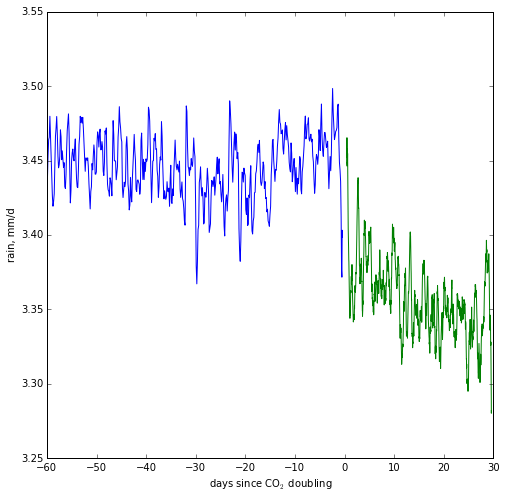

In [68]:
fig, ax = plt.subplots(1)
ax.plot(before.time_smooth, before.precip_smooth)
ax.plot(after.time_smooth, after.precip_smooth)
ax.set_xlabel('days since CO$_2$ doubling')
ax.set_ylabel('rain, mm/d')
ax.set_xlim(-60,30)
#fig.savefig('figures/precipitation_2xco2.pdf', bbox_inches = 0)

### Radiative Cooling

(-40, 30)

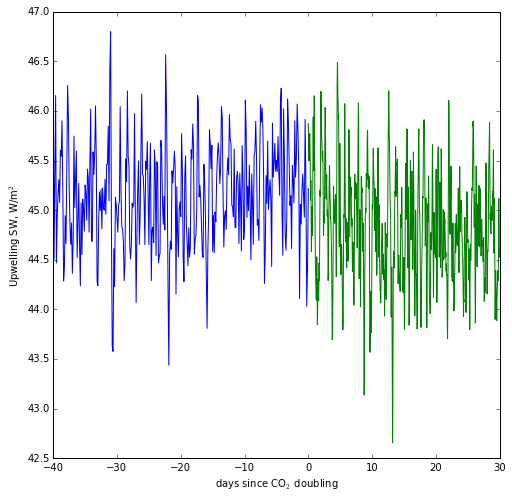

In [49]:
before.swup = before.variables_1d['swup']
after.swup = after.variables_1d['swup']
fig, ax = plt.subplots(1)
after.swup_smooth =  sm.smooth(after.swup,window_len = int(ratio))
ax.plot(before.time, before.swup)
ax.plot(after.time, after.swup_smooth)
ax.plot
ax.set_xlabel('days since CO$_2$ doubling')
ax.set_ylabel('Upwelling SW, W/m$^2$')
ax.set_xlim(-40,30)

(-40, 30)

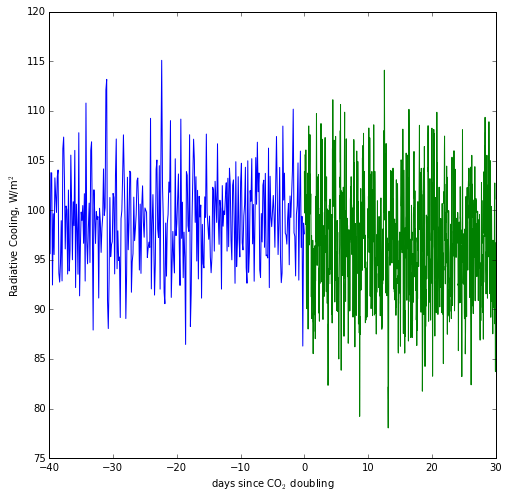

In [47]:
before.Le = before.variables_1d['Le']
after.Le = after.variables_1d['Le']
before.Lm = before.variables_1d['Lm']
after.Lm = after.variables_1d['Lm']
fig, ax = plt.subplots(1)
after.Le_smooth =  sm.smooth(after.Le,window_len = int(ratio))
after.Lm_smooth =  sm.smooth(after.Lm,window_len = int(ratio))
ax.plot(before.time, before.Le)
ax.plot(after.time, after.Le_smooth)
#ax.plot(before.time, before.Lm)
#ax.plot(after.time, after.Lm_smooth)
ax.plot
ax.set_xlabel('days since CO$_2$ doubling')
ax.set_ylabel('Radiative Cooling, W/m$^2$')
ax.set_xlim(-40,30)
#fig.savefig('figures/rad_cooling_2xco2.pdf', bbox_inches = 0)

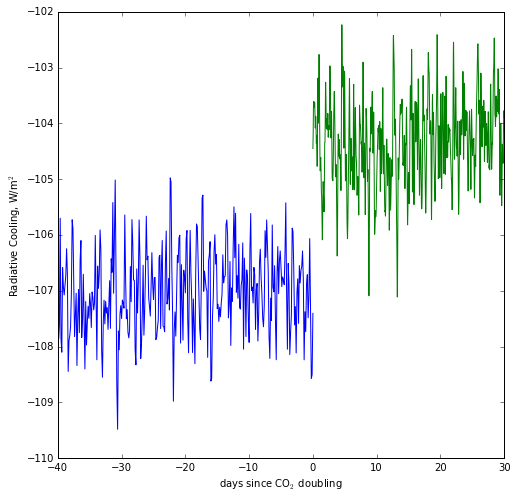

In [43]:
before.Q = before.variables_1d['Q']
after.Q = after.variables_1d['Q']
fig, ax = plt.subplots(1)
after.Q_smooth =  sm.smooth(after.Q,window_len = int(ratio))
ax.plot(before.time, before.Q)
ax.plot(after.time, after.Q_smooth)
ax.plot
ax.set_xlabel('days since CO$_2$ doubling')
ax.set_ylabel('Radiative Cooling, W/m$^2$')
ax.set_xlim(-40,30)
fig.savefig('figures/rad_cooling_2xco2.pdf', bbox_inches = 0)

### swdown

In [105]:
before.swdown = before.variables_2d['swdown']
after.swdown = after.variables_2d['swdown']

before.swup = before.variables_2d['swup']
after.swup = after.variables_2d['swup']

In [108]:
climo_down = profile(before.swdown, tb = np.where(before.time>-80.)[0][0])# use only last 80 days of pre-doubling run
after.swdown_anom = np.zeros(after.swdown.shape)
for i in range(after.swdown.shape[0]): 
    after.swdown_anom[i,:] = after.swdown[i,:] - climo_down
    
climo_up = profile(before.swup, tb = np.where(before.time>-80.)[0][0])# use only last 80 days of pre-doubling run
after.swup_anom = np.zeros(after.swup.shape)
for i in range(after.swup.shape[0]): 
    after.swup_anom[i,:] = after.swup[i,:] - climo_up

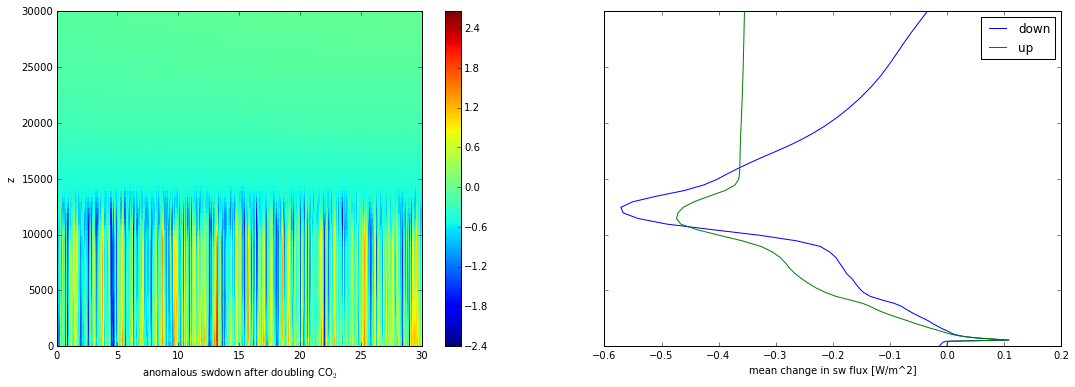

In [111]:
fig, (ax1,ax2) = plt.subplots(1, 2, sharey =True, figsize = (18,6))
im = ax1.pcolormesh(after.time, after.z, after.swdown_anom.transpose())
ax1.set_ylim(0,30000)
fig.colorbar(im , ax = ax1) 
ax2.plot(profile(after.swdown)-profile(before.swdown, tb = np.where(before.time>-80.)[0][0]),before.z,label='down')
ax2.plot(profile(after.swup)-profile(before.swup, tb = np.where(before.time>-80.)[0][0]),before.z,label='up')
ax2.set_xlabel('mean change in sw flux [W/m^2]')
ax1.set_xlabel('anomalous swdown after doubling CO$_2$')
ax1.set_ylabel('z')
plt.legend()
#fig.savefig('figures/cloudfraction_2xco2.png', bbox_inches = 0)

### Clouds

In [72]:
before.cloud = before.variables_2d['cloud']
after.cloud = after.variables_2d['cloud']

In [73]:
climo = profile(before.cloud, tb = np.where(before.time>-80.)[0][0])# use only last 80 days of pre-doubling run
after.cloud_anom = np.zeros(after.cloud.shape)
for i in range(after.cloud.shape[0]): 
    after.cloud_anom[i,:] = after.cloud[i,:] - climo

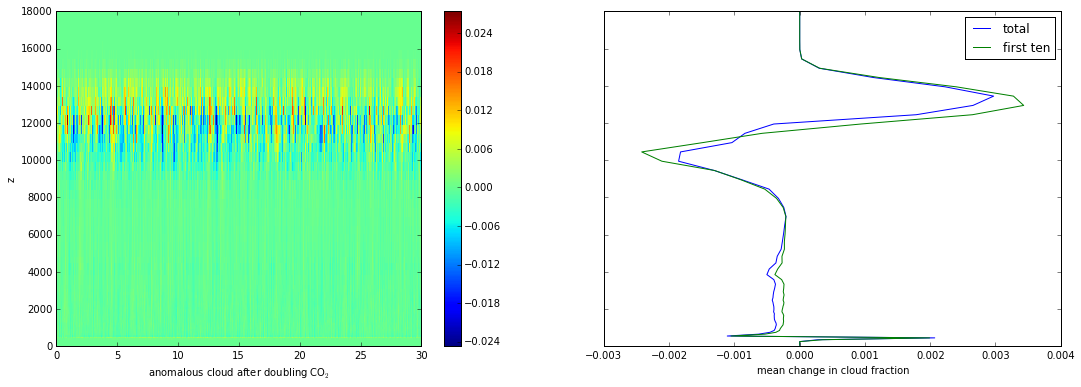

In [91]:
fig, (ax1,ax2) = plt.subplots(1, 2, sharey =True, figsize = (18,6))
im = ax1.pcolormesh(after.time, after.z, after.cloud_anom.transpose())
ax1.set_ylim(0,18000)
fig.colorbar(im , ax = ax1) 
ax2.plot(profile(after.cloud)-profile(before.cloud, tb = np.where(before.time>-80.)[0][0]),before.z,label='total')
ax2.plot(profile(after.cloud, tb = 0,te=np.where(after.time>10.)[0][0])-profile(before.cloud, tb = np.where(before.time>-80.)[0][0]),before.z,label='first ten')
#ax2.plot(profile(after.cloud, tb = np.where(after.time>20.)[0][0])-profile(before.cloud, tb = np.where(before.time>-80.)[0][0]),before.z,label='last ten')
ax2.set_xlabel('mean change in cloud fraction')
ax1.set_xlabel('anomalous cloud after doubling CO$_2$')
ax1.set_ylabel('z')
plt.legend()
#fig.savefig('figures/cloudfraction_2xco2.png', bbox_inches = 0)

### $\theta_e$

In [15]:
after.thetae = getvar('thetae',vstats_after)
before.thetae = variables_2d['thetae']

In [17]:
climo = profile(before.thetae, tb = np.where(before.time>-80.)[0][0])# use only last 80 days of pre-doubling run
after.thetae_anom = np.zeros(after.thetae.shape)
for i in range(after.thetae.shape[0]): 
    after.thetae_anom[i,:] = after.thetae[i,:] - climo

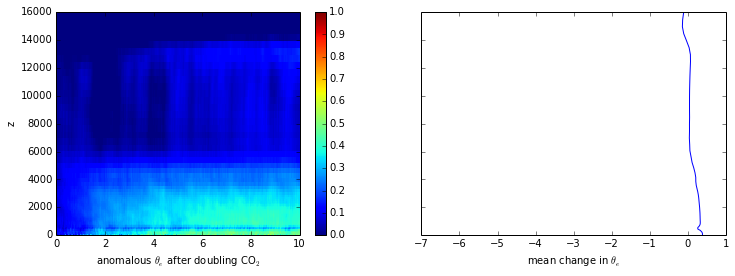

In [27]:
fig, (ax1,ax2) = plt.subplots(1, 2, sharey =True, figsize = (12,4))
im = ax1.pcolormesh(after.time, after.z, after.thetae_anom.transpose(), vmin = 0, vmax = 1)
ax1.set_ylim(0,16000)
fig.colorbar(im , ax = ax1) 
ax2.plot(profile(after.thetae)-profile(before.thetae, tb = np.where(before.time>-80.)[0][0]),before.z)
ax2.set_xlabel('mean change in $\\theta_e$')
ax1.set_xlabel('anomalous $\\theta_e$ after doubling CO$_2$')
ax1.set_ylabel('z')
fig.savefig('figures/thetae_2xco2.png', bbox_inches = 0)

### $q_c$, $q_i$

In [75]:
before.qc = before.variables_2d['qc']
after.qc = after.variables_2d['qc']

before.qi = before.variables_2d['qi']
after.qi = after.variables_2d['qi']

In [77]:
climo_c = profile(before.qc, tb = np.where(before.time>-80.)[0][0])# use only last 80 days of pre-doubling run
climo_i = profile(before.qi, tb = np.where(before.time>-80.)[0][0])# use only last 80 days of pre-doubling run

after.qc_anom = np.zeros(after.qc.shape)
after.qi_anom = np.zeros(after.qc.shape)
for i in range(after.qc.shape[0]): 
    after.qc_anom[i,:] = after.qc[i,:] - climo_c
    after.qi_anom[i,:] = after.qi[i,:] - climo_i

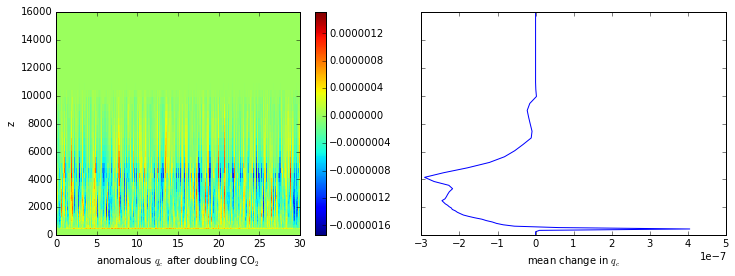

In [78]:
fig, (ax1,ax2) = plt.subplots(1, 2, sharey =True, figsize = (12,4))
im = ax1.pcolormesh(after.time, after.z, after.qc_anom.transpose())
ax1.set_ylim(0,16000)
fig.colorbar(im , ax = ax1) 
ax2.plot(profile(after.qc,tb = np.where(after.time>5.)[0][0])-profile(before.variables_2d['qc'], tb = np.where(before.time>-80.)[0][0]),before.z)
ax2.set_xlabel('mean change in $q_c$')
ax1.set_xlabel('anomalous $q_c$ after doubling CO$_2$')
ax1.set_ylabel('z')
fig.savefig('figures/qc_2xco2.png', bbox_inches = 0)

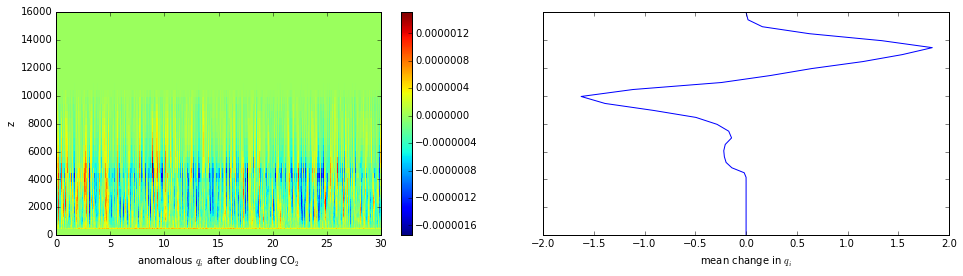

In [87]:
fig, (ax1,ax2) = plt.subplots(1, 2, sharey =True, figsize = (16,4))
im = ax1.pcolormesh(after.time, after.z, after.qc_anom.transpose())
ax1.set_ylim(0,16000)
fig.colorbar(im , ax = ax1) 
ax2.plot(1.e7*(profile(after.qi,tb = np.where(after.time>5.)[0][0])-profile(before.variables_2d['qi'], tb = np.where(before.time>-80.)[0][0])),before.z)
#ax2.plot(1.e7*climo_i,before.z)
ax2.set_xlabel('mean change in $q_i$')
ax1.set_xlabel('anomalous $q_i$ after doubling CO$_2$')
ax1.set_ylabel('z')
#fig.savefig('figures/qc_2xco2.png', bbox_inches = 0)

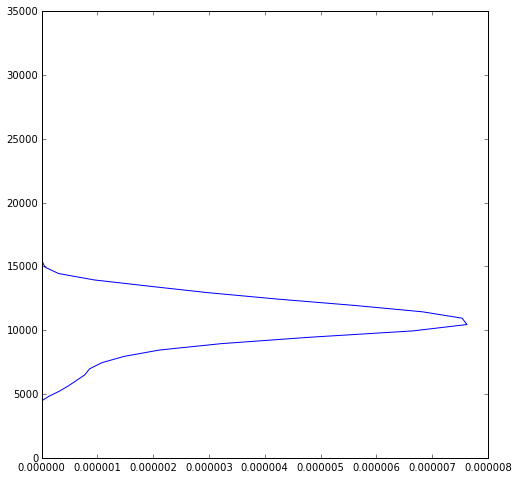

In [84]:
plt.plot(climo_i,before.z)